In [1]:
import os
from os.path import dirname
import sys
import gymnasium as gym
import torch
from copy import deepcopy
from tqdm import tqdm
try:
    dir_ = dirname(dirname(__file__))
except Exception as e:
    dir_ = dirname(dirname('__file__'))

if len(dir_) == 0:
    dir_ = dirname(os.getcwd())

print(dir_)
sys.path.append(dir_)
from RLAlgo.TD3 import TD3
from RLUtils import Config
import numpy as np
from RLUtils.env_wrapper import FrameStack, CarV2SkipFrame, GrayScaleObservation, ResizeObservation
import matplotlib.pyplot as plt
import cv2

/home/scc/sccWork/myGitHub/RL/src


In [2]:
def random_action(env):
    try:
        return np.random.uniform(env.action_space.low, env.action_space.high)
    except Exception as e:
        return env.action_space.sample()
    

# CarRacing-v2

In [3]:
env_name = 'CarRacing-v2'
env_ = gym.make(env_name, render_mode=None)
env_.action_space.low, env_.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

[-0.24217129  0.07640936  0.35926245]
======================== SET SKIP_N = 5 ========================


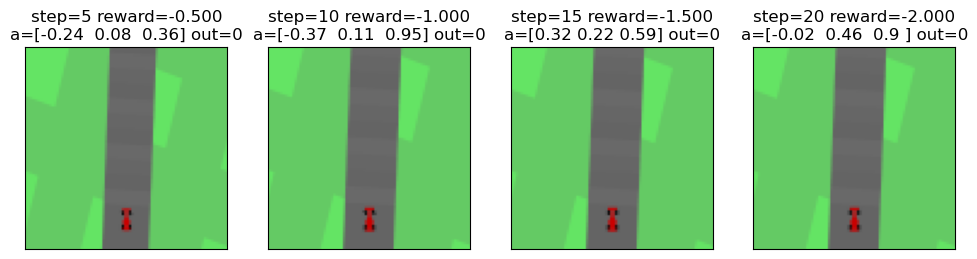

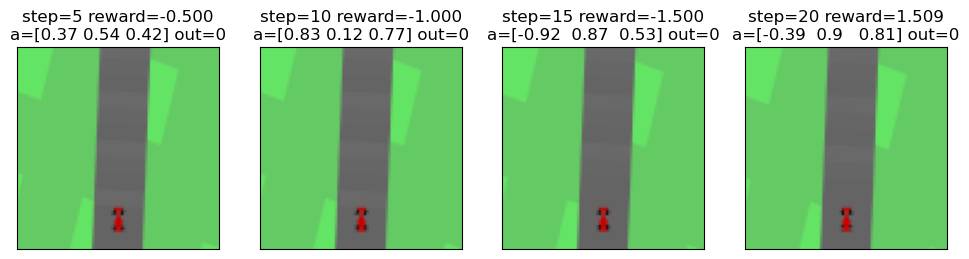

In [4]:
s, info = env_.reset()
a = np.array([0.0, 0.0, 1.0])
for i in range(40):
    obs, reward, done, info, _ = env_.step(a)

a = random_action(env_)
print(a)
SKIP_N = 5
print(f"======================== SET SKIP_N = {SKIP_N} ========================")
tt_r = 0
fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * 4)):
    s, reward, done, info1, info2 = env_.step(a)
    # plt.imshow(s)
    # plt.show()
    s = s[:84, 6:90]
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        axes[ax_idx].imshow(s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        out = ((s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()) == 4
        out *= 1
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s} out={out}')
        ax_idx += 1
        a = random_action(env_)

plt.show()

tt_r = 0
fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * 4)):
    s, reward, done, info1, info2 = env_.step(a)
    s = s[:84, 6:90]
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        axes[ax_idx].imshow(s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        out = ((s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()) == 4
        out *= 1
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s} out={out}')
        ax_idx += 1
        a = random_action(env_)

plt.show()


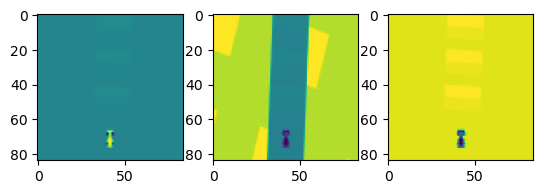

In [5]:
fig, axes = plt.subplots(1, 3)
# s = obs[:84, 6:90]
for i in range(3):
    axes[i].imshow(s[:, :, i])

# red green blue
plt.show()

In [6]:
print(s.shape)
print(s[75, :, 1])

# > 200
# s[75, 30:50, 0], 
s[75, 35:50, 1], (s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()

(84, 84, 3)
[202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202
 202 202 202 202 202 202 215 228 228 228 228 228 228 175 100 100 100 100
 100 100 100  95  53  11  11  53  95 100 100 100 100 100 100 100 164 202
 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202 202
 202 202 202 202 202 202 202 202 202 202 202 202]


(array([100, 100, 100, 100,  95,  53,  11,  11,  53,  95, 100, 100, 100,
        100, 100], dtype=uint8),
 0)

In [7]:
torch.normal(0, 1, (2, 2))

tensor([[ 0.4028,  0.7446],
        [ 0.1513, -0.6177]])

## preprocessing Obs

In [8]:
env = gym.make(env_name)
SKIP_N = 5
STACK_N = 4
env_ = FrameStack(
    ResizeObservation(
        GrayScaleObservation(CarV2SkipFrame(env, skip=SKIP_N)), 
        shape=84
    ), 
    num_stack=STACK_N
)

[-0.22944944  0.12159651  0.66467229]


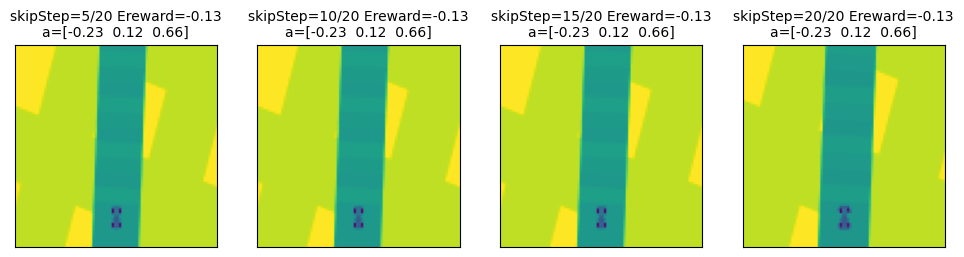

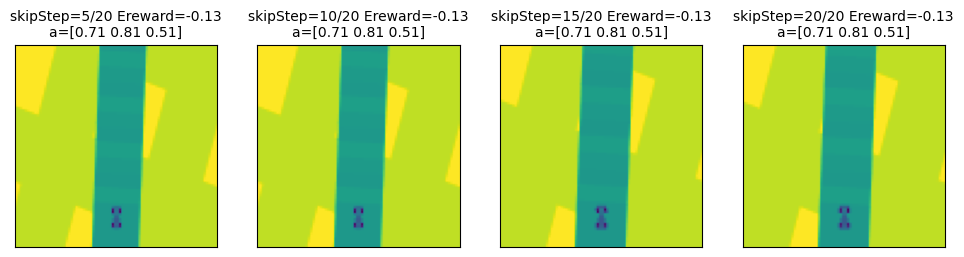

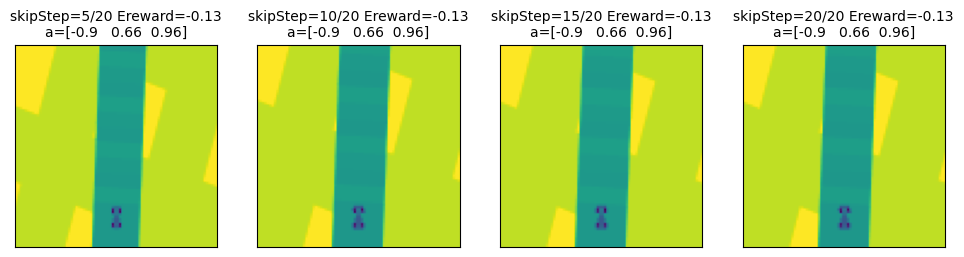

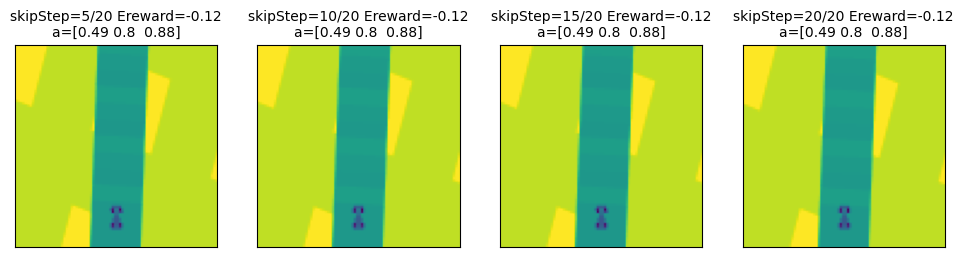

In [9]:
s, info = env_.reset()
a = random_action(env_)
print(a)
for step_i in range(4):
    s, reward, done, info1, info2 = env_.step(a)
    fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
    for ax_idx, pic in enumerate(s._frames):
        axes[ax_idx].imshow(pic)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(
            f'skipStep={SKIP_N * (ax_idx+1)}/{SKIP_N * STACK_N} Ereward={reward/4:.2f}\na={a_s}',
            fontsize=10
        )

    if done:
        plt.show()
        break
    a = random_action(env_)
    plt.show()

In [10]:
from torch.nn import functional as F
path_ = os.path.dirname('__file__')

cfg = Config(
    env, 
    # 环境参数
    save_path=os.path.join(path_, "test_models" ,'TD3_CarRacing-v2_test2-3'), 
    seed=42,
    # 网络参数
    actor_hidden_layers_dim=[128], # 256
    critic_hidden_layers_dim=[128],
    # agent参数
    actor_lr=2.5e-4, #5.5e-5,
    critic_lr=1e-3, #7.5e-4,  
    gamma=0.99,
    # 训练参数
    num_episode=15000,
    sample_size=128,
    # 环境复杂多变，需要保存多一些buffer
    off_buffer_size=1024*100,  
    off_minimal_size=256,
    max_episode_rewards=50000,
    max_episode_steps=1200, # 200
    # agent 其他参数
    TD3_kwargs={
        'CNN_env_flag': 1,
        'pic_shape': env.observation_space.shape,
        "env": env,
        'action_low': env.action_space.low,
        'action_high': env.action_space.high,
        # soft update parameters
        'tau': 0.05, 
        # trick2: Delayed Policy Update
        'delay_freq': 1,
        # trick3: Target Policy Smoothing
        'policy_noise': 0.2,
        'policy_noise_clip': 0.5,
        # exploration noise
        'expl_noise': 0.5,
        # 探索的 noise 指数系数率减少 noise = expl_noise * expl_noise_exp_reduce_factor^t
        'expl_noise_exp_reduce_factor':  1 - 1e-4
    }
)
agent = TD3(
    state_dim=cfg.state_dim,
    actor_hidden_layers_dim=cfg.actor_hidden_layers_dim,
    critic_hidden_layers_dim=cfg.critic_hidden_layers_dim,
    action_dim=cfg.action_dim,
    actor_lr=cfg.actor_lr,
    critic_lr=cfg.critic_lr,
    gamma=cfg.gamma,
    TD3_kwargs=cfg.TD3_kwargs,
    device=cfg.device
)

agent.load_model(cfg.save_path)
agent.eval()

Set env random_seed = 42

device=cuda | env=<TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>(state_dim=3, action_dim=3)
TD3_kwargs => {'CNN_env_flag': 1, 'pic_shape': (96, 96, 3), 'env': <TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>, 'action_low': array([-1.,  0.,  0.], dtype=float32), 'action_high': array([1., 1., 1.], dtype=float32), 'tau': 0.05, 'delay_freq': 1, 'policy_noise': 0.2, 'policy_noise_clip': 0.5, 'expl_noise': 0.5, 'expl_noise_exp_reduce_factor': 0.9999}
[-1.  0.  0.] [1. 1. 1.]
action_bound= <TimeLimit<OrderEnforcing<PassiveEnvChecker<CarRacing<CarRacing-v2>>>>>


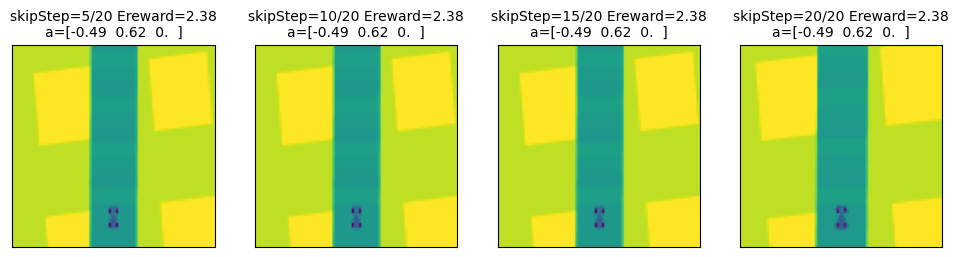

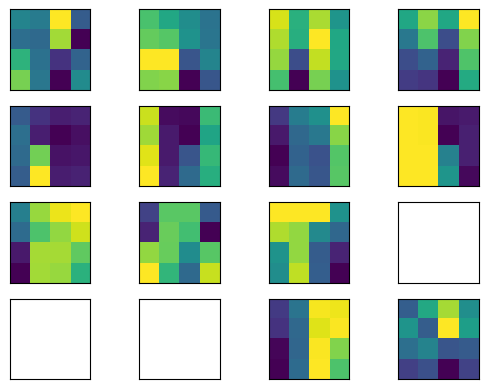

In [25]:
agent.train()
s, info = env_.reset()
for step_i in range(4):
    s_pt = torch.tensor([np.stack(s)]).float().to(agent.device)
    a = agent.policy(s)
    a_pt = torch.tensor([a]).float().to(agent.device)
    n_s, reward, done, info1, info2 = env_.step(a)
    fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
    for ax_idx, pic in enumerate(n_s._frames):
        axes[ax_idx].imshow(pic)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(
            f'skipStep={SKIP_N * (ax_idx+1)}/{SKIP_N * STACK_N} Ereward={reward/4 + 2.5:.2f}\na={a_s}',
            fontsize=10
        )
        
    # 计算目标Q
    ns_pt = torch.tensor([np.stack(n_s)]).float().to(agent.device)
    smooth_act = agent.smooth_action(ns_pt).to(agent.device)
    # trick1: **Clipped Double Q-learning**: critic中有两个`Q-net`, 每次产出2个Q值，使用其中小的
    target_Q1, target_Q2 = agent.target_critic(ns_pt, smooth_act)
    target_Q = torch.minimum(target_Q1, target_Q2)
    target_Q = reward + (1.0 - done) * agent.gamma * target_Q
    # 计算当前Q值
    current_Q1, current_Q2 = agent.critic(s_pt, a_pt)
    q_loss = F.mse_loss(current_Q1.float(), target_Q.float().detach()) + F.mse_loss(current_Q2.float(), target_Q.float().detach())
    agent.critic_opt.zero_grad()
    q_loss.backward()
    s = n_s
    break


for n, p in agent.critic.q1_cnn_feature[0].named_parameters():
    if n == 'bias':
        continue
    fig, axes = plt.subplots(4, 4)
    axes = axes.flatten()
    for i, p_g in enumerate(p.grad.sum(dim=1)):
        p_g = p_g / p_g.max()
        axes[i].imshow(p_g.cpu().detach().numpy())
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.show()
    break

In [29]:
agent.critic.q1_cnn_feature

Sequential(
  (0): Conv2d(4, 16, kernel_size=(4, 4), stride=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
)

In [19]:
agent.eval()
s1, info = env_.reset()
a = random_action(env_)
print(a)
tt_r = []
for step_i in range(20):
    s, reward, done, info1, info2 = env_.step(a)
    a = agent.policy(s)
    print(np.round(a, 3))

[-0.68796272  0.15599452  0.05808361]
[1. 1. 1.]
[0.71  0.737 0.455]
[0.538 0.    1.   ]
[1.    0.238 0.527]
[0.629 0.648 0.   ]
[0.685 1.    1.   ]
[1.    1.    0.483]
[0.7   1.    0.887]
[0.682 0.489 0.66 ]
[0.733 0.997 0.626]
[1.    0.368 1.   ]
[1.   1.   0.85]
[1.    0.496 0.   ]
[1.    0.731 0.068]
[0.56  0.435 0.808]
[1. 1. 1.]
[1.    0.896 0.429]
[0.246 1.    0.652]
[0.795 1.    0.292]
[1.    1.    0.222]


  0%|          | 0/120 [00:00<?, ?it/s]

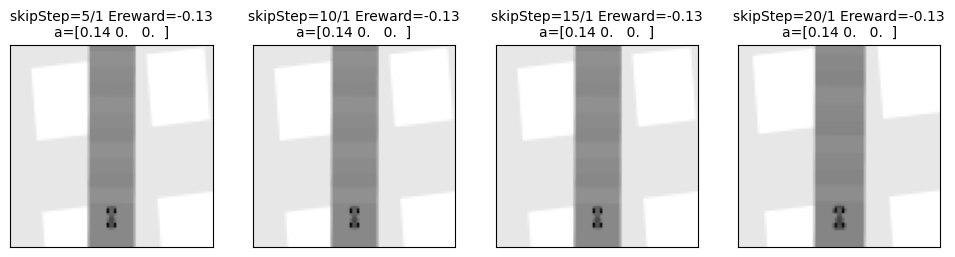

  1%|          | 1/120 [00:00<00:12,  9.62it/s]

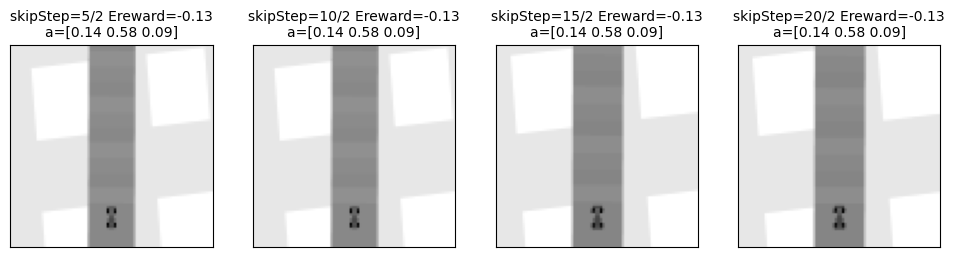

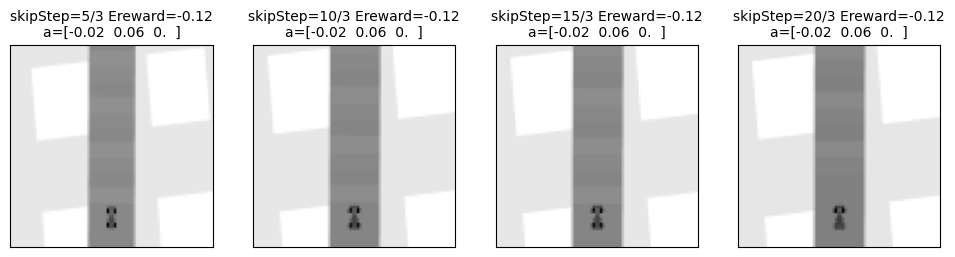

  2%|▎         | 3/120 [00:00<00:10, 10.77it/s]

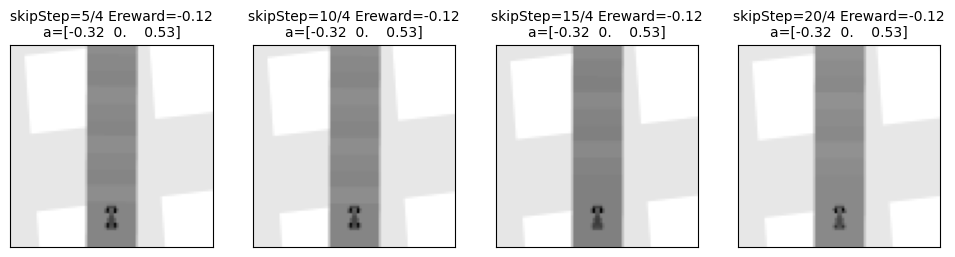

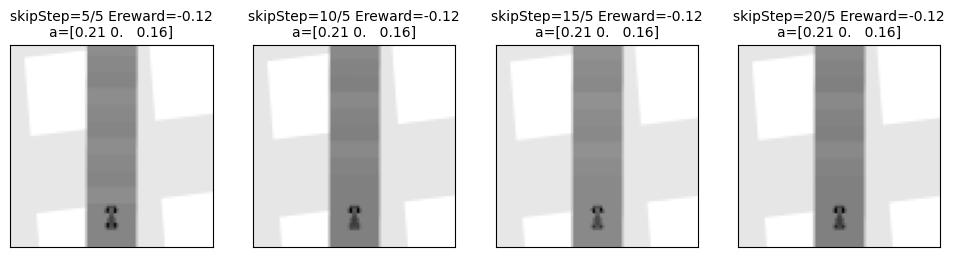

  4%|▍         | 5/120 [00:00<00:10, 11.03it/s]

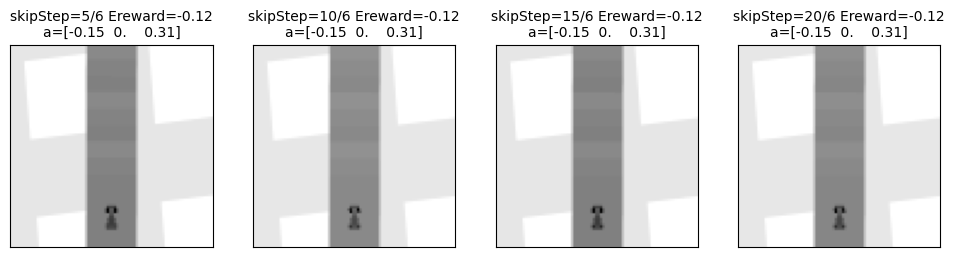

 89%|████████▉ | 107/120 [00:02<00:00, 48.56it/s]

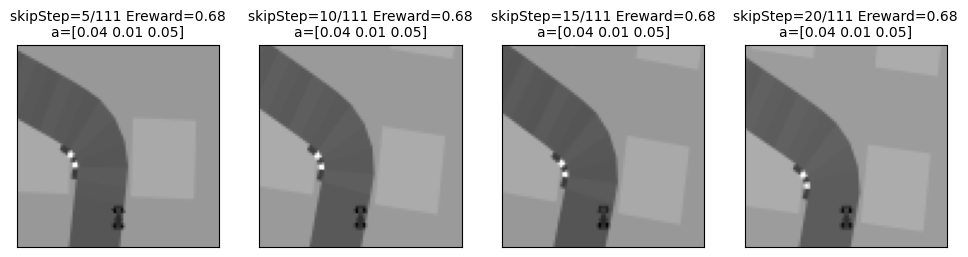

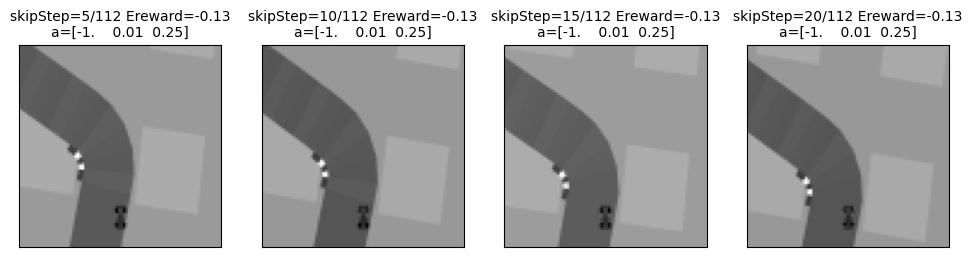

 93%|█████████▎| 112/120 [00:03<00:00, 27.50it/s]

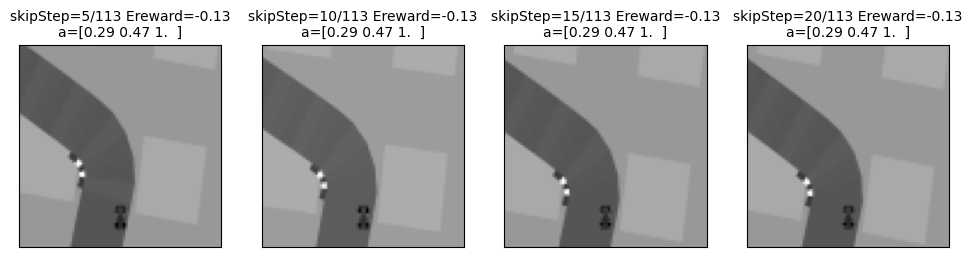

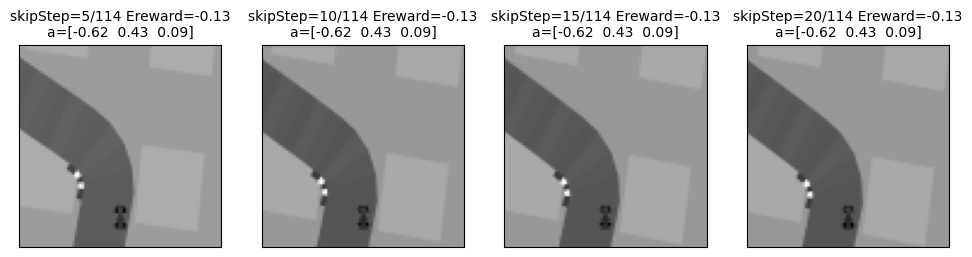

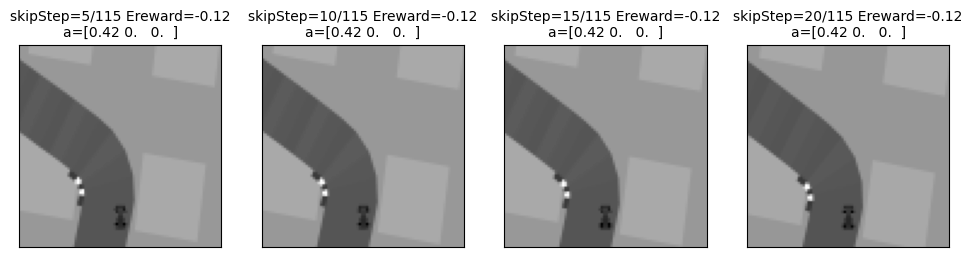

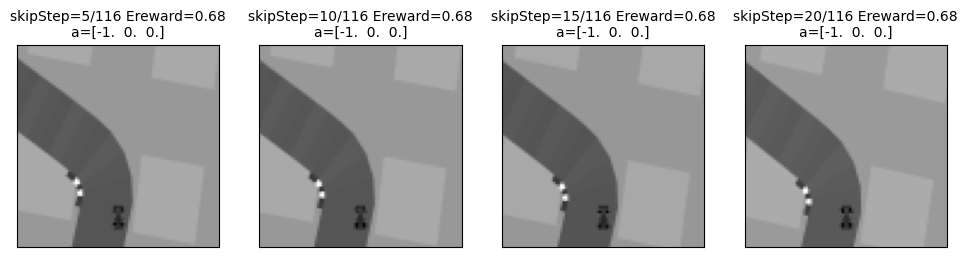

 97%|█████████▋| 116/120 [00:03<00:00, 19.84it/s]

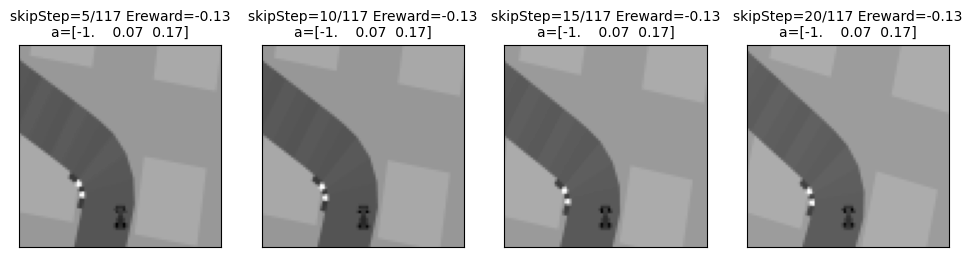

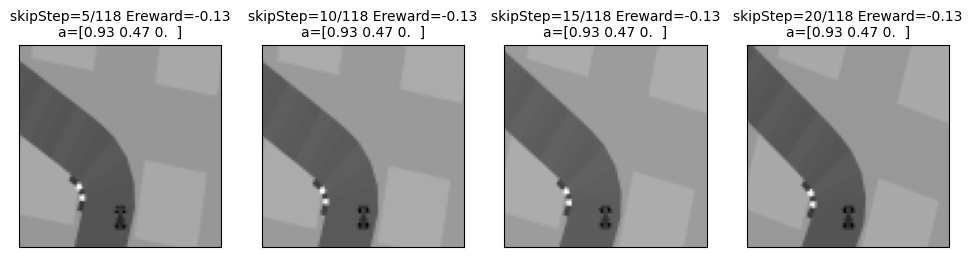

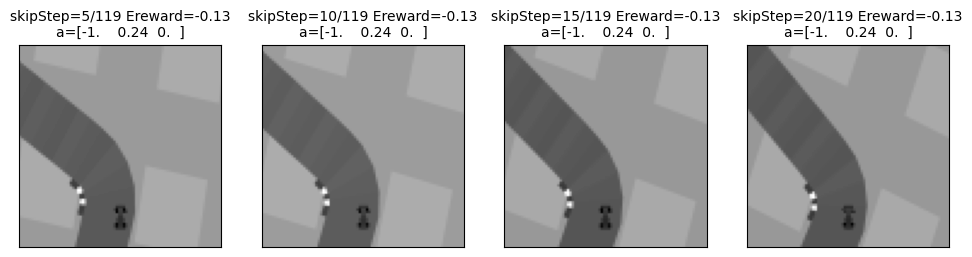

 99%|█████████▉| 119/120 [00:03<00:00, 16.83it/s]

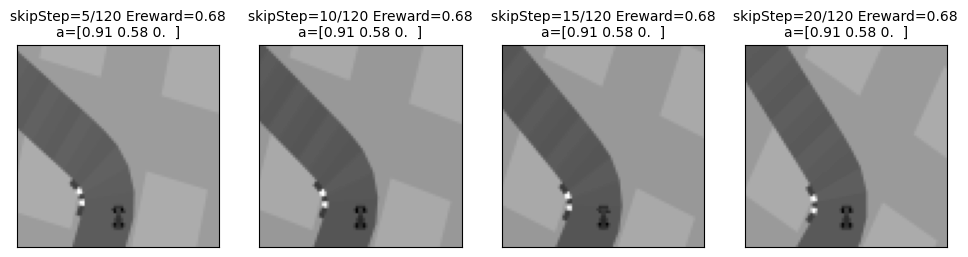

100%|██████████| 120/120 [00:03<00:00, 32.04it/s]

[-0.5000000000000004, -0.5000000000000003, -0.4999999999999999, -0.5, -0.5, -0.5, 2.7051282051282044, -0.5000000000000004, -0.5, -0.4999999999999999, -0.5, -0.4999999999999999, 2.705128205128205, -0.5000000000000004, -0.5000000000000002, 2.7051282051282053, -0.5000000000000004, -0.5000000000000004, -0.5000000000000004, 2.7051282051282053, -0.4999999999999982, -0.49999999999999956, 2.705128205128205, -0.4999999999999982, -0.4999999999999982, 2.705128205128206, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, 2.705128205128206, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, 2.705128205128207, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, 2.705128205128207, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.4999999999999982, -0.49999999999999

In [26]:
from  tqdm import tqdm
s, info = env_.reset()
# a = random_action(env_)
tt_r = []
for step_i in tqdm(range(120)):
    a = agent.policy(s)
    s, reward, done, info1, info2 = env_.step(a)
    tt_r.append(reward)
    if (step_i >= 110) or (step_i <= 5):
        fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
        for ax_idx, pic in enumerate(s._frames):
            axes[ax_idx].imshow(pic, cmap='gray')
            axes[ax_idx].set_xticks([])
            axes[ax_idx].set_yticks([])
            a_s = np.round(a, 2)
            axes[ax_idx].set_title(
                f'skipStep={SKIP_N * (ax_idx+1)}/{step_i + 1} Ereward={reward/4:.2f}\na={a_s}',
                fontsize=10
            )

        if done:
            plt.show()
            print(f"step_i={step_i}")
            break
        plt.show()

print(tt_r)
print(np.sum(tt_r))

In [117]:
s_sp = s._frames[-1] 
s_sp[s_sp > 0.627]

torch.Size([1710])

# ALE/DemonAttack-v5

In [3]:
env_name = 'ALE/DemonAttack-v5'
env_ = gym.make(env_name, obs_type="rgb", render_mode='rgb_array')
# env_.action_space.low, env_.action_space.high
env_.action_space

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Discrete(6)

In [16]:
# pic_cut_slices = [[15, 188], [0, 160]]
# slice_list = []
# for idx, dim_i_slice in enumerate(pic_cut_slices):
#     slice_list.append(eval('np.s_[{st}:{ed}]'.format(st=dim_i_slice[0], ed=dim_i_slice[1])))

# obs[tuple(i for i in slice_list)].shape

0
======================== SET SKIP_N = 4 ========================


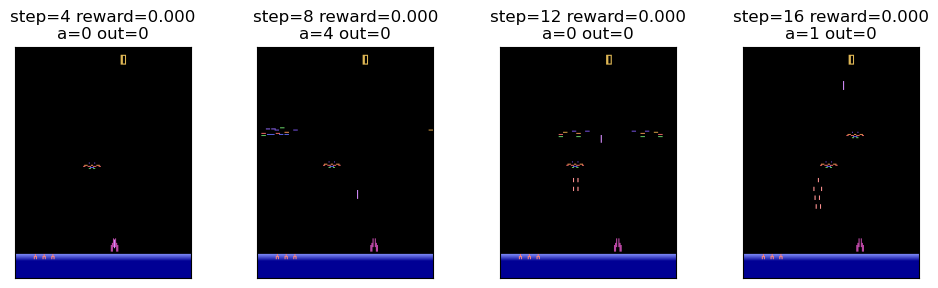

In [4]:
# env start
s, info = env_.reset()
a = np.array(0)
for i in range(14):
    obs, reward, done, info, _ = env_.step(a)

# plt.imshow(obs)
# plt.show()
a = random_action(env_)
print(a)
SKIP_N = 4
print(f"======================== SET SKIP_N = {SKIP_N} ========================")
tt_r = 0
fig, axes = plt.subplots(1, 4, figsize=(4*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * 4)):
    s, reward, done, info1, info2 = env_.step(a)
    # plt.imshow(s)
    # plt.show()
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        axes[ax_idx].imshow(s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        out = ((s[75, 35:50, 1][:2] > 200).sum() + (s[75, 35:50, 1][-2:] > 200).sum()) == 4
        out *= 1
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s} out={out}')
        ax_idx += 1
        a = random_action(env_)

plt.show()

In [15]:
193-15

178

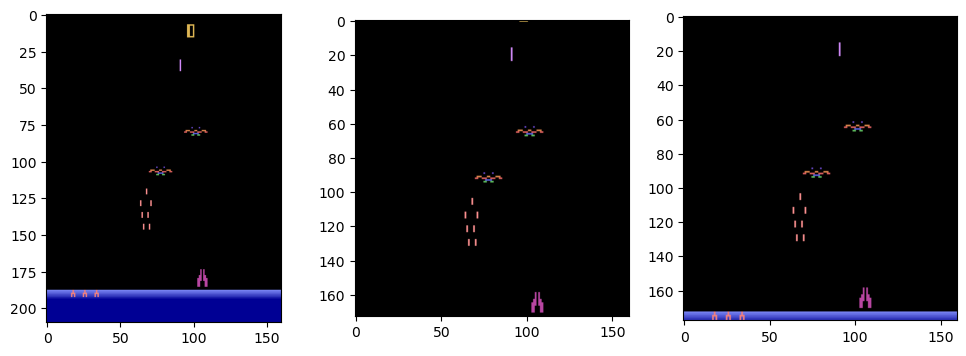

In [18]:
# pic cut
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(s)
axes[1].imshow(s[15:188, :160, :])
axes[2].imshow(s[15:193, :160, :])
plt.show()

# ALE/DoubleDunk-v5

In [3]:
env_name = 'ALE/DoubleDunk-v5'
env_ = gym.make(env_name, obs_type="rgb", render_mode='rgb_array')
env_.action_space

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Discrete(18)

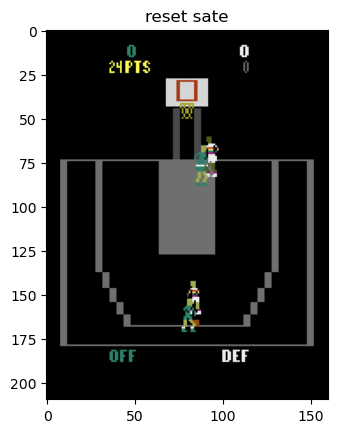

{'lives': 0, 'episode_frame_number': 17, 'frame_number': 2309}


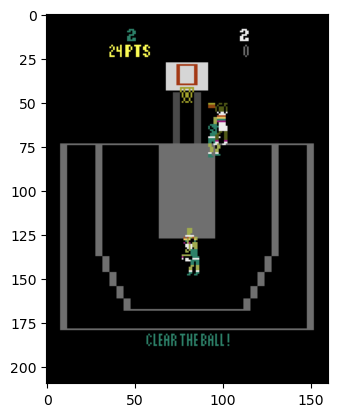

In [18]:
s, info = env_.reset()
plt.imshow(s)
plt.title("reset sate")
plt.show()

print(info)
for i in range(200):
    a = random_action(env_)
    obs, reward, done, t, info = env_.step(a)
    if done or t:
        print(a, done or t, info)


plt.imshow(obs)
plt.show()

## 3分线内外 & 犯规探索

In [44]:
def ball_owner_judge_v1(state):
    height, width = 210, 160
    org_arr = np.zeros((height, width), dtype=np.uint8)
    polygon_vertices = np.array([
        [29, 74],
        [29, 139],
        [46, 167],
        [114, 167],
        [130, 139],
        [130, 74]
    ], dtype=np.int32)
    inner_step = 8
    polygon_vertices_small = np.array([
        [29+inner_step, 74],
        [29+inner_step, 139],
        [46+inner_step, 167-inner_step-6],
        [114-inner_step, 167-inner_step-6],
        [130-inner_step, 139],
        [130-inner_step, 74]
    ], dtype=np.int32)
    # generate 
    image = cv2.fillPoly(deepcopy(org_arr), [polygon_vertices], color=(1, 0, 0))
    a = deepcopy(state[:, :, 0])
    a[image==1] = 255 # mask
    
    image_small = cv2.fillPoly(deepcopy(org_arr), [polygon_vertices_small], color=(1, 0, 0))
    a_small = deepcopy(state[:, :, 0])
    a_small[image_small==1] = 255 # mask
    
    # person green 45 white 236
    green_socker = 45
    white_socker = 236
    green_out_3 = (a[76:175, :]==green_socker).sum() >= 1
    green_judge_one = (a[168:175, :]==green_socker).sum() >= 1
    white_out_3 = (a[76:175, :]==white_socker).sum() >= 1  
    white_judge_one = (a[168:175, :]==white_socker).sum() >= 1

    ball = [144, 160]
    whole_see_ball = ((state[:, :, 0]==ball[0]).sum() >= 1) or ((state[:, :, 0]==ball[1]).sum() >= 1)
    ball_out_3 = ((a_small[76:175, :]==ball[0]).sum() >= 1) or ((a_small[76:175, :]==ball[1]).sum() >= 1)
    see_ball = whole_see_ball and ball_out_3
    green_ball = (see_ball and green_out_3) #or ((not see_ball) and (not ball_out_3) and green_out_3)
    white_ball = (see_ball and white_out_3) #or ((not see_ball) and (not ball_out_3) and white_out_3)
    return green_ball, white_ball  and (not green_ball), green_judge_one, white_judge_one

In [45]:
def ball_owner_judge(state):
    height, width = 210, 160
    org_arr = np.zeros((height, width), dtype=np.uint8)
    polygon_vertices = np.array([
        [29, 74],
        [29, 139],
        [46, 167],
        [114, 167],
        [130, 139],
        [130, 74]
    ], dtype=np.int32)
    a = deepcopy(state[:, :, 0])
    image = cv2.fillPoly(deepcopy(org_arr), [polygon_vertices], color=(1, 0, 0))
    a[image==1] = 255 # mask
    inner_step = 8
    polygon_vertices_small = np.array([
        [29+inner_step, 74],
        [29+inner_step, 139],
        [46+inner_step, 145],
        [114-inner_step, 145],
        [130-inner_step, 139],
        [130-inner_step, 74]
    ], dtype=np.int32)
    image_small = cv2.fillPoly(deepcopy(org_arr), [polygon_vertices_small], color=(1, 0, 0))
    a_small = deepcopy(state[:, :, 0])
    a_small[image_small==1] = 255 # mask
    
    # person green 45 white 236
    green_socker = 45
    white_socker = 236
    ball = [144]
    bool_ = (a_small[76:175, :] == ball[0]) 
    ball_out_3 = bool_.sum() >= 1
    out_3_bool = ((a[76:175, :] == green_socker) | (a[76:175, :] == white_socker)).sum() >= 1
    if not (ball_out_3 & out_3_bool):
        return False, False, False, False
    
    #
    green_out_3 = (a[76:175, :]==green_socker).sum() >= 1
    green_judge_one = (a[168:175, :]==green_socker).sum() >= 1
    white_out_3 = (a[76:175, :]==white_socker).sum() >= 1  
    white_judge_one = (a[168:175, :]==white_socker).sum() >= 1
    if not (green_out_3 & white_out_3):
        green_ball = (out_3_bool and green_out_3) #or ((not see_ball) and (not ball_out_3) and green_out_3)
        white_ball = (out_3_bool and white_out_3) #or ((not see_ball) and (not ball_out_3) and white_out_3)
        return green_ball, white_ball  and (not green_ball), green_judge_one, white_judge_one
    # near_pic
    col_ = np.arange(160)
    row_ = np.arange(175-76)

    col_min, col_max = col_[bool_.sum(axis=0) > 0].min(), col_[bool_.sum(axis=0) > 0].max()
    row_min, row_max = row_[bool_.sum(axis=1) > 0].min(), row_[bool_.sum(axis=1) > 0].max()

    ball_near_pic = ball_near_pic = a_small[76:175, :][
        max(row_min-10, 0):min(row_max+10, 159), 
        max(col_min-6, 0):min(col_max+6, 175-76-1)
    ]
    green_cnt = (ball_near_pic == green_socker).sum()
    white_cnt = (ball_near_pic == white_socker).sum()

    return green_cnt > white_cnt, white_cnt > green_cnt, False, False

In [7]:
# 3分线内

res = []
for i in tqdm(range(50)):
    s, info = env_.reset()
    for _ in range(2):
        s, reward, done, t, info = env_.step(np.array(0))
    g_b, w_b, _, _ = ball_owner_judge(s)
    res.append([g_b, w_b])
    # if not my_ball  and see_ball:
    #     break
    # # 45 -green
    # print(my_out_3)

    # fig, axes = plt.subplots(1, 2)
    # axes[0].imshow(a_small)
    # axes[0].set_title(f'{ball_out_3=}')
    # axes[1].imshow(s[:, :, 0]==144)
    # axes[1].set_title(f'{my_ball=} | {see_ball=}')
    # plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 239.18it/s]


In [8]:
# fig, axes = plt.subplots(1, 2)
# axes[0].imshow(a_small)
# axes[0].set_title(f'{ball_out_3=}')
# axes[1].imshow(s[:, :, 0]==144)
# axes[1].set_title(f'{my_ball=} | {see_ball=}')
# plt.show()
# plt.imshow(s)
# plt.show()

import pandas as pd 
res_df = pd.DataFrame(res, columns=['g_b', 'w_b'])
res_df

,g_b,w_b
0,False,False
1,False,False
2,False,False
3,True,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


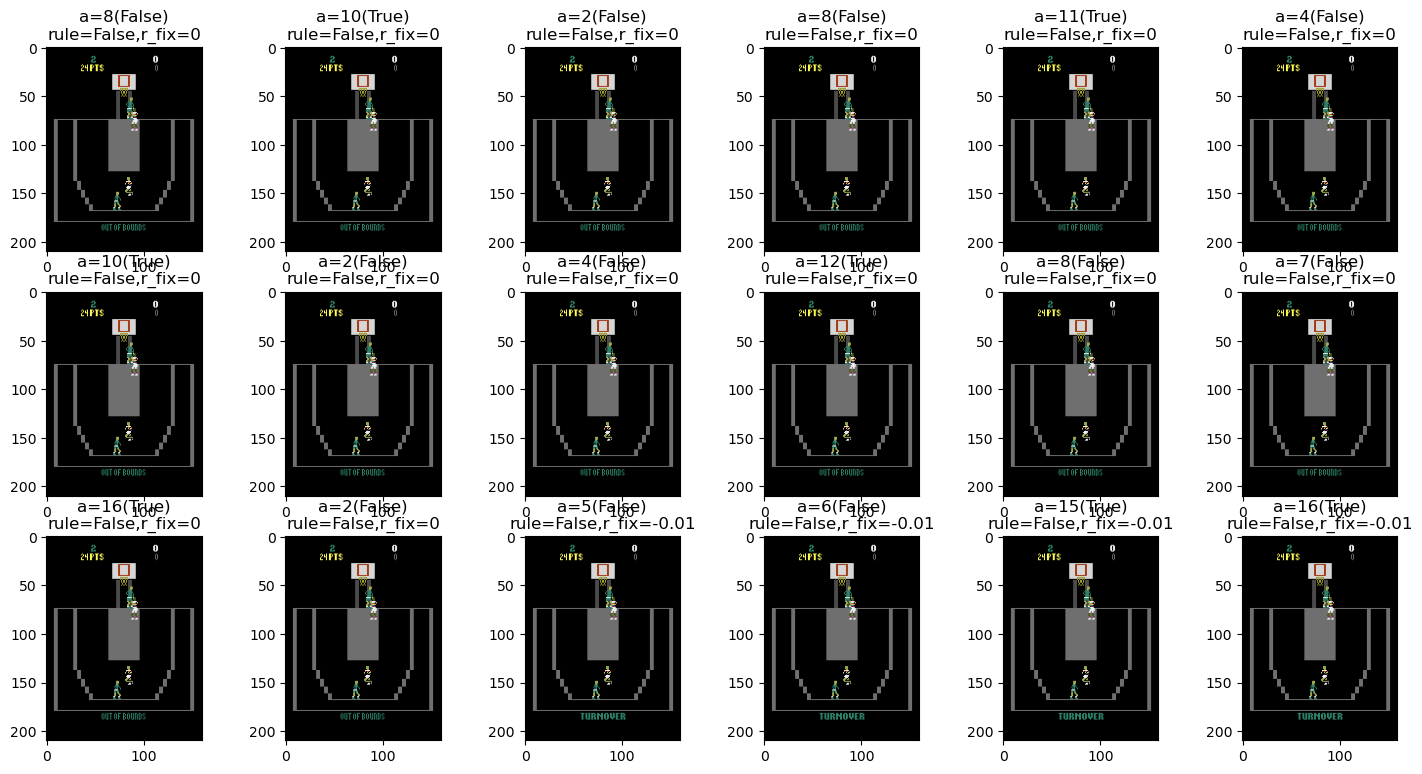

In [61]:
# s, info = env_.reset()
# owner_now = 'green'
# before_res = 'green'
fig, axes = plt.subplots(3, 6, figsize=(6*3, 9))
axes = axes.flatten()
s_l = []
a_l = []
for i in range(18):
    a = random_action(env_)
    s, reward, done, t, info = env_.step(a)
    s_l.append(s)
    a_l.append(a)
    g_b, w_b, g_one, w_one = ball_owner_judge(s)
    if (g_b and before_res == 'green') or (g_b and g_one):
        owner_now = 'green'
    if (w_b and before_res == 'white') or (w_b and w_one):
        owner_now = 'white'

    if g_b: 
        before_res = 'green' 
    if w_b: 
        before_res = 'white' 
    # all false remean
    fire_a = a in [1] + list(range(10, 18))
    T_sum = (s[180:190, 75:80, 0] == 45).sum()
    clear_ball_obs = (T_sum >= 7) and (T_sum <= 9)
    trun_over_obs = (s[180:190, 55:105, 0] == 45).sum() >= 165
    r_fix = 0
    if trun_over_obs:
        r_fix -= 0.01
    if clear_ball_obs:
        r_fix = r_fix + ( -0.01 if fire_a else 0.001)
    axes[i].imshow(s)
    # axes[i].set_title(f'{before_res=}\n{owner_now=}|rule={clear_ball_obs}')
    axes[i].set_title(f'{a=}({fire_a})\nrule={clear_ball_obs},{r_fix=}')
plt.show()

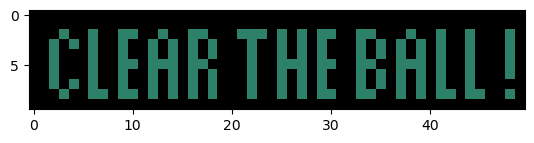

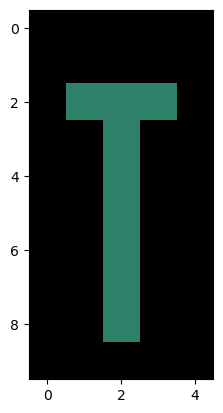

[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0 45 45 45  0]
 [ 0  0 45  0  0]
 [ 0  0 45  0  0]
 [ 0  0 45  0  0]
 [ 0  0 45  0  0]
 [ 0  0 45  0  0]
 [ 0  0 45  0  0]
 [ 0  0  0  0  0]] 9


In [59]:
## CLEAR THE BALL
clean_obs = deepcopy(s_l[0])

plt.imshow(clean_obs[180:190, 55:105, :])
plt.show()
plt.imshow(clean_obs[180:190, 75:80, :])
plt.show()
print(clean_obs[180:190, 75:80, 0], (clean_obs[180:190, 75:80, 0]==45).sum())

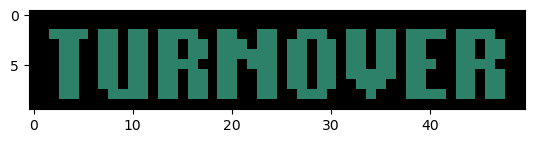

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 45 45 45 45  0 45 45  0 45 45  0 45 45 45 45  0  0 45 45  0  0 45
  45  0  0 45 45 45  0  0 45 45  0 45 45  0 45 45 45 45  0 45 45 45 45  0
   0  0]
 [ 0  0  0 45 45  0  0 45 45  0 45 45  0 45 45  0 45 45  0 45 45 45  0 45
  45  0 45 45  0 45 45  0 45 45  0 45 45  0 45 45  0  0  0 45 45  0 45 45
   0  0]
 [ 0  0  0 45 45  0  0 45 45  0 45 45  0 45 45  0 45 45  0 45 45 45 45 45
  45  0 45 45  0 45 45  0 45 45  0 45 45  0 45 45  0  0  0 45 45  0 45 45
   0  0]
 [ 0  0  0 45 45  0  0 45 45  0 45 45  0 45 45 45 45  0  0 45 45  0 45 45
  45  0 45 45  0 45 45  0 45 45  0 45 45  0 45 45 45  0  0 45 45 45 45  0
   0  0]
 [ 0  0  0 45 45  0  0 45 45  0 45 45  0 45 45  0 45 45  0

In [66]:
## CLEAR THE BALL
trun_obs = deepcopy(s_l[-1])
plt.imshow(trun_obs[180:190, 55:105, :])
plt.show()
print(trun_obs[180:190, 55:105, 0], (trun_obs[180:190, 55:105, 0]==45).sum())

Text(0.5, 1.0, '13')

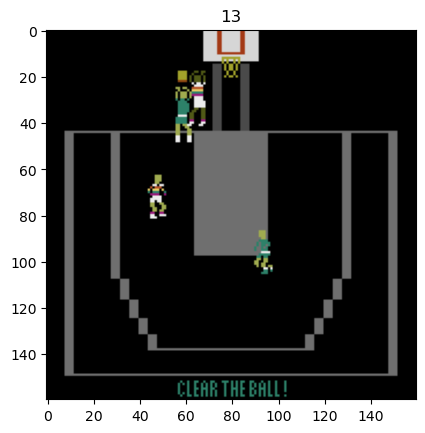

In [82]:
obs = deepcopy(s_l[-1])
# obs = obs[30:191, :, :]
# add_arr = np.zeros((5,) + obs.shape[1:]) + 255
# obs[-5:, :, :] = add_arr
plt.imshow(obs[180:190, 55:105, :])
plt.imshow(obs[30:190, :, :])
plt.title(a_l[-1])

In [287]:
obs = s_l[1]
now_ = 'green'
add_arr = np.zeros(obs.shape[1:]) + (255 if now_ == 'green' else 0)
np.concatenate([add_arr[np.newaxis, :], obs], axis=0).shape

(211, 160, 3)

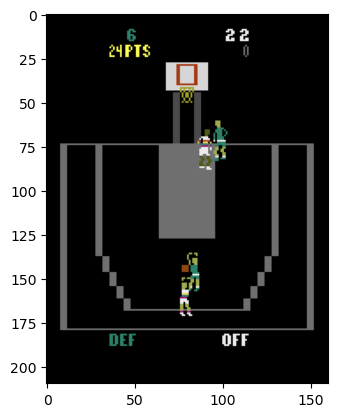

In [257]:
state = s_l[1]
plt.imshow(state)
plt.show()

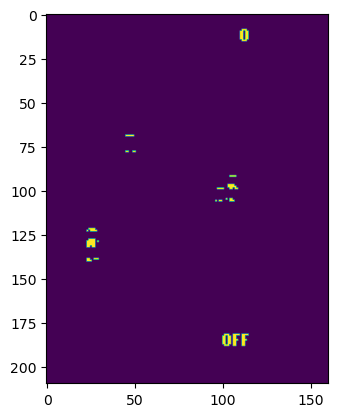

In [18]:
plt.imshow(state[:, : , 2] == 236) # [100:125, 40:50, 0]
plt.show()

## 图层和图像大小

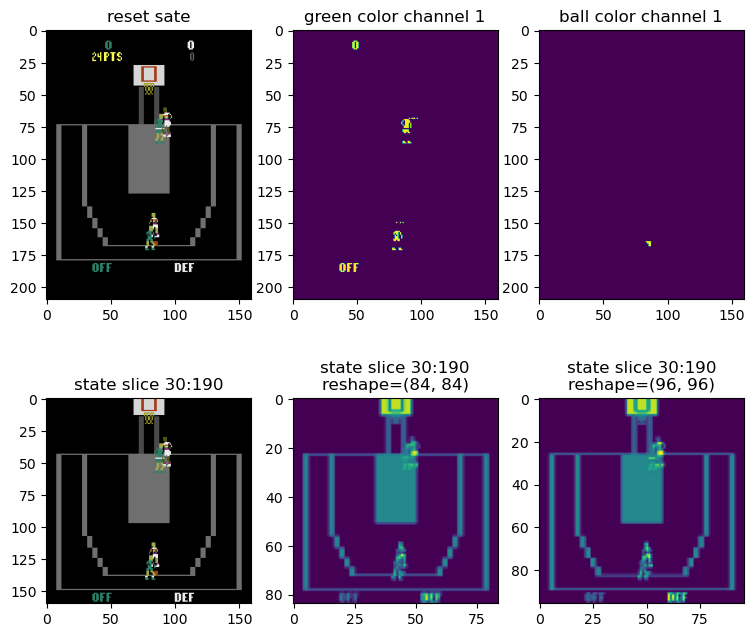

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(3*3, 2*4))
axes = axes.flatten()

axes[0].imshow(s)
axes[0].set_title("reset sate")

axes[1].imshow(s[:, :, 0] == 45)
axes[1].set_title("green color channel 1")

axes[2].imshow(s[:, :, 0] == 144)
axes[2].set_title("ball color channel 1")


axes[3].imshow(s[30:190, :, :])
axes[3].set_title("state slice 30:190")

# reshape
res_l = []
obs = s[30:190, :, :]
grey_s = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
for idx, shape in enumerate([(84, 84), (96, 96)]):
    re_s = cv2.resize(grey_s,  shape, interpolation=cv2.INTER_AREA) 
    axes[4+idx].imshow(re_s)
    axes[4+idx].set_title(f"state slice 30:190\nreshape={shape}")
    res_l.append(re_s)

plt.show()

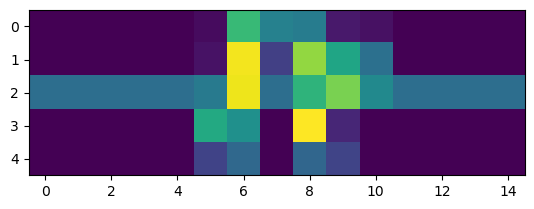

[[  0   0   0   0   0   5 108  70  67  11   7   0   0   0   0]
 [  0   0   0   0   0   8 157  30 134  94  59   0   0   0   0]
 [ 58  58  58  58  58  66 156  58 104 128  76  58  58  58  58]
 [  0   0   0   0   0  97  80   0 160  17   0   0   0   0   0]
 [  0   0   0   0   0  32  54   0  53  33   0   0   0   0   0]]


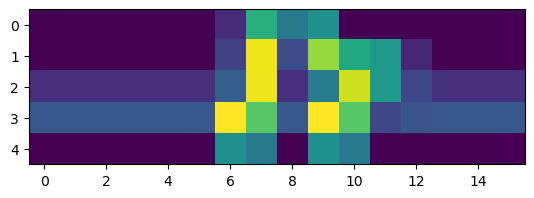

[[  0   0   0   0   0   0  20 101  65  81   0   0   0   0   0   0]
 [  0   0   0   0   0   0  31 157  38 136  98  87  17   0   0   0]
 [ 22  22  22  22  22  22  49 157  22  68 149  87  35  22  22  22]
 [ 44  44  44  44  44  44 161 119  44 161 119  35  42  44  44  44]
 [  0   0   0   0   0   0  81  65   0  81  65   0   0   0   0   0]]


In [43]:
plt.imshow(res_l[0][70:75, 35:50])
plt.show()
print(res_l[0][70:75, 35:50])
plt.imshow(res_l[1][80:85, 40:56])
plt.show()
print(res_l[1][80:85, 40:56])

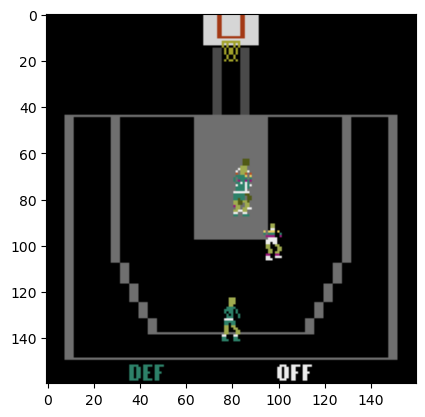

In [27]:
slice_list = []
pic_cut_slices = [[30, 190]]
for idx, dim_i_slice in enumerate(pic_cut_slices):
    slice_list.append(eval('np.s_[{st}:{ed}]'.format(st=dim_i_slice[0], ed=dim_i_slice[1])))

obs = obs[tuple(i for i in slice_list)]
plt.imshow(obs)
plt.show()

2
======================== SET SKIP_N = 1 ========================


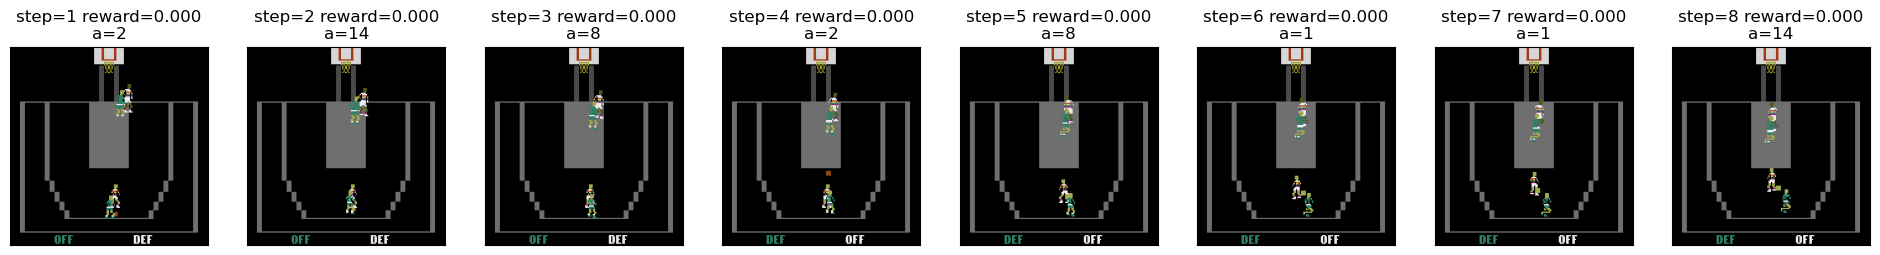

In [45]:

s, info = env_.reset()
a = random_action(env_)
shape = (96, 96)
print(a)
SKIP_N = 1
STACK_N = 8
print(f"======================== SET SKIP_N = {SKIP_N} ========================")
tt_r = 0
fig, axes = plt.subplots(1, STACK_N, figsize=(STACK_N*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * STACK_N)):
    s, reward, done, info1, info2 = env_.step(a)
    # plt.imshow(s)
    # plt.show()
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        obs = s[30:190, :, :]
        axes[ax_idx].imshow(obs)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s}')
        ax_idx += 1
        a = random_action(env_)
        re_s = cv2.resize(s,  shape, interpolation=cv2.INTER_AREA) 
plt.show()

# ALE/Bowling-v5

In [3]:
env_name = 'ALE/Bowling-v5'
env_ = gym.make(env_name, obs_type="rgb", render_mode='rgb_array')
env_.action_space

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Discrete(6)

In [4]:
env_.unwrapped.get_action_meanings()[1], \
env_.unwrapped.get_action_meanings()

('FIRE', ['NOOP', 'FIRE', 'UP', 'DOWN', 'UPFIRE', 'DOWNFIRE'])

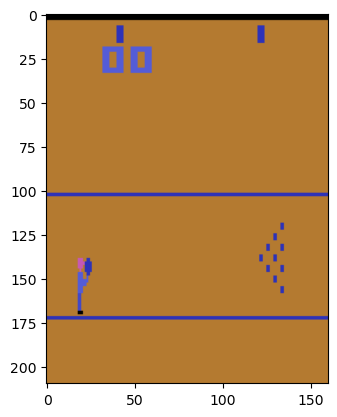

In [5]:
s, info = env_.reset()
plt.imshow(s)
plt.show()

1
======================== SET SKIP_N = 2 ========================


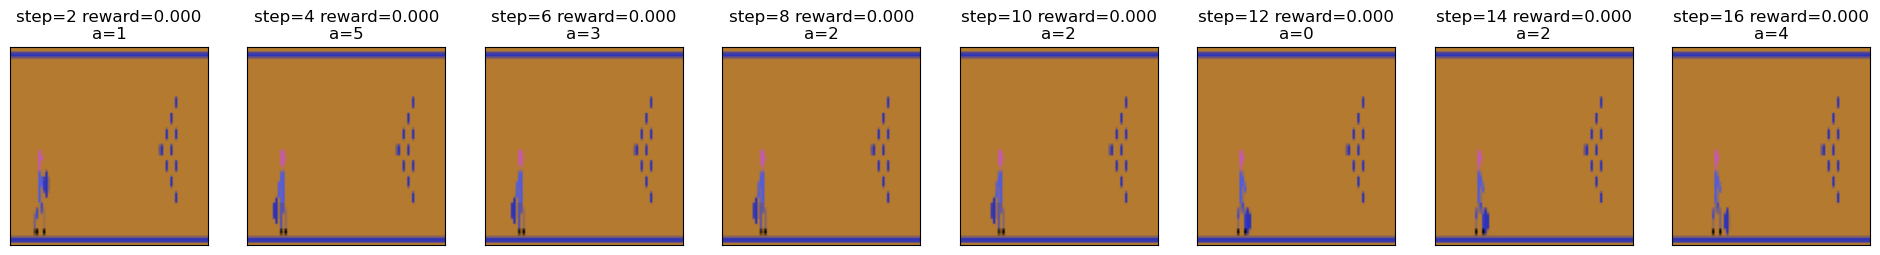

In [11]:

s, info = env_.reset()
a = 1 #  random_action(env_)
shape = (84, 84)
print(a)
SKIP_N = 2
STACK_N = 8
print(f"======================== SET SKIP_N = {SKIP_N} ========================")
tt_r = 0
fig, axes = plt.subplots(1, STACK_N, figsize=(STACK_N*3, 3))
ax_idx = 0
for idx, i in enumerate(range(SKIP_N * STACK_N)):
    s, reward, done, info1, info2 = env_.step(a)
    # plt.imshow(s)
    # plt.show()
    tt_r += reward
    if (1+idx) % SKIP_N == 0:
        obs = s[100:175, :, :]
        re_s = cv2.resize(obs,  shape, interpolation=cv2.INTER_AREA) 
        axes[ax_idx].imshow(re_s)
        axes[ax_idx].set_xticks([])
        axes[ax_idx].set_yticks([])
        a_s = np.round(a, 2)
        axes[ax_idx].set_title(f'step={idx+1} reward={tt_r:.3f}\na={a_s}')
        ax_idx += 1
        a = random_action(env_)
        
plt.show()